## Mini Project

In [1]:
import time
import numpy as np

## Feature Extraction - VGG16

VGG16 is pre-trained model. We use transfer learning to apply this model to extract features from MNIST.

In [2]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
import numpy as np
from numpy.random import RandomState

prng = RandomState(42)
num = 5000
#Extract a subset of 5000 samples from MNIST training
random_permute=prng.permutation(np.arange(0,60000))[0:num]

In [4]:
x = np.zeros((num, 28, 28))
y = np.zeros(num)
for i in range(x.shape[0]):
  x[i] = x_train[random_permute[i]]
  y[i] = y_train[random_permute[i]]

In [5]:
import cv2

def change_size(x):
  x_resize = np.zeros((x.shape[0], 224, 224))
  for i in range(x.shape[0]):
    x_resize[i] = cv2.resize(x[i], (224, 224))

  x_channel = x_resize[:,:,:,np.newaxis]
  x_final = np.concatenate( (x_channel,x_channel), axis=3 )
  x_final = np.concatenate( (x_final,x_channel), axis=3 )
  return x_final

In [6]:
x_input = change_size(x)

In [7]:
from keras.applications.vgg16 import VGG16, preprocess_input

x_input = preprocess_input(x_input)

In [8]:
vgg16_base_model = VGG16(weights='imagenet', include_top=True)

Instructions for updating:
Colocations handled automatically by placer.


Here, we change the last part of VGG16.

In [92]:
from keras.models import Model

# vgg16_model = Model(inputs=vgg16_base_model.input, outputs=vgg16_base_model.get_layer('fc2').output)
vgg16_model = Model(inputs=vgg16_base_model.input, outputs=vgg16_base_model.get_layer('fc1').output)
# vgg16_model = Model(inputs=vgg16_base_model.input, outputs=vgg16_base_model.get_layer('fc1').input)

In [93]:
import time

start = time.time()

vgg16_feature = vgg16_model.predict(x_input, batch_size = 8)
vgg16_label = y

end = time.time()
end - start

856.6603858470917

In [12]:
vgg16_feature.shape

(5000, 4096)

## Mean & Covariance Computation

In [162]:
features = vgg16_feature
labels = vgg16_label

features.shape, labels.shape

((5000, 4096), (5000,))

In [163]:
num_sample=features.shape[0]
num_feature=features.shape[1]

### global mean of features 
over all samples  
µG - 4096*1  

In [164]:
mean_global = np.mean(features, axis=0)

In [165]:
features.shape

(5000, 4096)

### class-means   
µc - 4096*10

In [166]:
features_classified=[]

for c in range(10):
    sample_order = np.where(labels == c)[0]
    features_single_class = np.zeros((len(sample_order), num_feature))
    for i in range(len(sample_order)):
        features_single_class[i] = features[sample_order[i]]
    features_classified.append(features_single_class)

In [167]:
mean_class = np.zeros((num_feature, 10))
mean_class_transpose = mean_class.T

for c in range(10):
    means_single_class = np.mean(features_classified[c], axis=0)
    mean_class_transpose[c] = means_single_class

mean_class=mean_class_transpose.T

In [168]:
mean_class.shape

(4096, 10)

### total covariance matrix

In [169]:
covariance_total = np.zeros((num_feature, num_feature))

for i in range(num_sample):
    fi_i = features[i].reshape(num_feature, 1)
    mu_g = mean_global.reshape(num_feature, 1)
    covariance_total += np.dot(fi_i, mu_g.T)
    
covariance_total = covariance_total/num_sample

In [170]:
covariance_total

array([[2.55217802e-03, 1.09797819e-01, 7.91751813e-02, ...,
        1.55408098e-01, 2.59189721e-02, 2.82703817e-01],
       [1.09797857e-01, 4.72363804e+00, 3.40621429e+00, ...,
        6.68584869e+00, 1.11506625e+00, 1.21622680e+01],
       [7.91751596e-02, 3.40621215e+00, 2.45621879e+00, ...,
        4.82116091e+00, 8.04073510e-01, 8.77020315e+00],
       ...,
       [1.55408076e-01, 6.68584543e+00, 4.82116157e+00, ...,
        9.46316177e+00, 1.57826670e+00, 1.72144952e+01],
       [2.59189663e-02, 1.11506561e+00, 8.04073553e-01, ...,
        1.57826656e+00, 2.63223393e-01, 2.87103431e+00],
       [2.82703868e-01, 1.21622660e+01, 8.77020715e+00, ...,
        1.72145007e+01, 2.87103547e+00, 3.13150029e+01]])

### between class covariance

In [171]:
covariance_between_class = np.zeros((num_feature, num_feature))

for c in range(10):
    mean_diff = (mean_class[:,c]-mean_global).reshape(num_feature, 1)
    covariance_between_class += np.dot(mean_diff, mean_diff.T)
    
covariance_between_class = covariance_between_class/num_feature

In [172]:
covariance_between_class

array([[ 7.12504011e-06, -1.15416381e-04, -5.52958034e-05, ...,
         1.59234046e-05, -1.76092986e-05, -3.84055947e-07],
       [-1.15416381e-04,  3.56787909e-03,  6.99674363e-04, ...,
        -3.64198760e-04,  4.71054392e-04,  3.16101680e-04],
       [-5.52958034e-05,  6.99674363e-04,  8.59746674e-04, ...,
        -1.19543690e-04,  8.40793869e-06,  2.38681095e-04],
       ...,
       [ 1.59234046e-05, -3.64198760e-04, -1.19543690e-04, ...,
         2.33367260e-03, -3.23444392e-04, -7.97732000e-04],
       [-1.76092986e-05,  4.71054392e-04,  8.40793869e-06, ...,
        -3.23444392e-04,  2.58776251e-04,  1.70960742e-04],
       [-3.84055947e-07,  3.16101680e-04,  2.38681095e-04, ...,
        -7.97732000e-04,  1.70960742e-04,  1.82484000e-03]])

###  within class covariance

In [173]:
covariance_within_class = np.zeros((num_feature, num_feature))

for c in range(10):
    for i in range(features_classified[c].shape[0]):
        fi_i_c = features_classified[c][i,:].reshape(num_feature, 1)
        mu_g = mean_class[:,c].reshape(num_feature, 1)
        covariance_within_class += np.dot(fi_i_c, mu_g.T)
        
covariance_within_class = covariance_within_class/num_sample

In [174]:
covariance_within_class

array([[5.46607989e-03, 6.35241623e-02, 5.58803931e-02, ...,
        1.61530981e-01, 1.89099563e-02, 2.81934061e-01],
       [6.35241623e-02, 6.13720275e+00, 3.69306765e+00, ...,
        6.55557825e+00, 1.30086556e+00, 1.22932205e+01],
       [5.58803931e-02, 3.69306765e+00, 2.81693056e+00, ...,
        4.77503865e+00, 8.07229830e-01, 8.87554814e+00],
       ...,
       [1.61530981e-01, 6.55557825e+00, 4.77503865e+00, ...,
        1.03923501e+01, 1.44912049e+00, 1.68968054e+01],
       [1.89099563e-02, 1.30086556e+00, 8.07229830e-01, ...,
        1.44912049e+00, 3.69893342e-01, 2.94027108e+00],
       [2.81934061e-01, 1.22932205e+01, 8.87554814e+00, ...,
        1.68968054e+01, 2.94027108e+00, 3.20811160e+01]])

In [175]:
covariance_verify = covariance_total-covariance_between_class-covariance_within_class
np.mean(covariance_verify), np.std(covariance_verify)

(-0.008968395039866904, 0.27523885392380665)

In [176]:
covariance_verify

array([[-2.92102691e-03,  4.63890730e-02,  2.33500840e-02, ...,
        -6.13880683e-03,  7.02662513e-03,  7.70139663e-04],
       [ 4.63891115e-02, -1.41713259e+00, -2.87553044e-01, ...,
         1.30634638e-01, -1.86270358e-01, -1.31268578e-01],
       [ 2.33500623e-02, -2.87555174e-01, -3.61571517e-01, ...,
         4.62418063e-02, -3.16472794e-03, -1.05583677e-01],
       ...,
       [-6.13882843e-03,  1.30631380e-01,  4.62424676e-02, ...,
        -9.31521984e-01,  1.29469652e-01,  3.18487534e-01],
       [ 7.02661933e-03, -1.86270997e-01, -3.16468525e-03, ...,
         1.29469519e-01, -1.06928725e-01, -6.94077285e-02],
       [ 7.70190773e-04, -1.31270633e-01, -1.05579669e-01, ...,
         3.18493033e-01, -6.94065705e-02, -7.67938032e-01]])

In [179]:
tr = np.trace(np.dot(covariance_within_class, np.linalg.pinv(covariance_between_class)))/10
tr

-104882337175701.72

###  closeness to equal-norms of class-means

In [161]:
norm2 = np.ones(10)

for c in range(10):
    mean_single_class = mean_class[:,c]
    mean_diff = mean_single_class - mean_global
    norm2[c] = np.linalg.norm(mean_diff, ord=2, keepdims=True)

std_class_norm2 = np.std(norm2)
mean_class_norm2 = np.mean(norm2)
closeness_equal_norms_class_mean = std_class_norm2/mean_class_norm2

In [157]:
std_class_norm2, mean_class_norm2, closeness_equal_norms_class_mean

(9.735266601495843, 48.522392673424456, 0.20063451254389222)

## Visualize

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.style as style 
import matplotlib.pyplot as plt
import matplotlib

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### PCA of VGG16

In [15]:
start = time.time()

vgg16_pca_embedded = PCA(n_components=2).fit_transform(vgg16_feature)  
vgg16_pca_embedded.shape

end = time.time()
end - start

0.6254193782806396

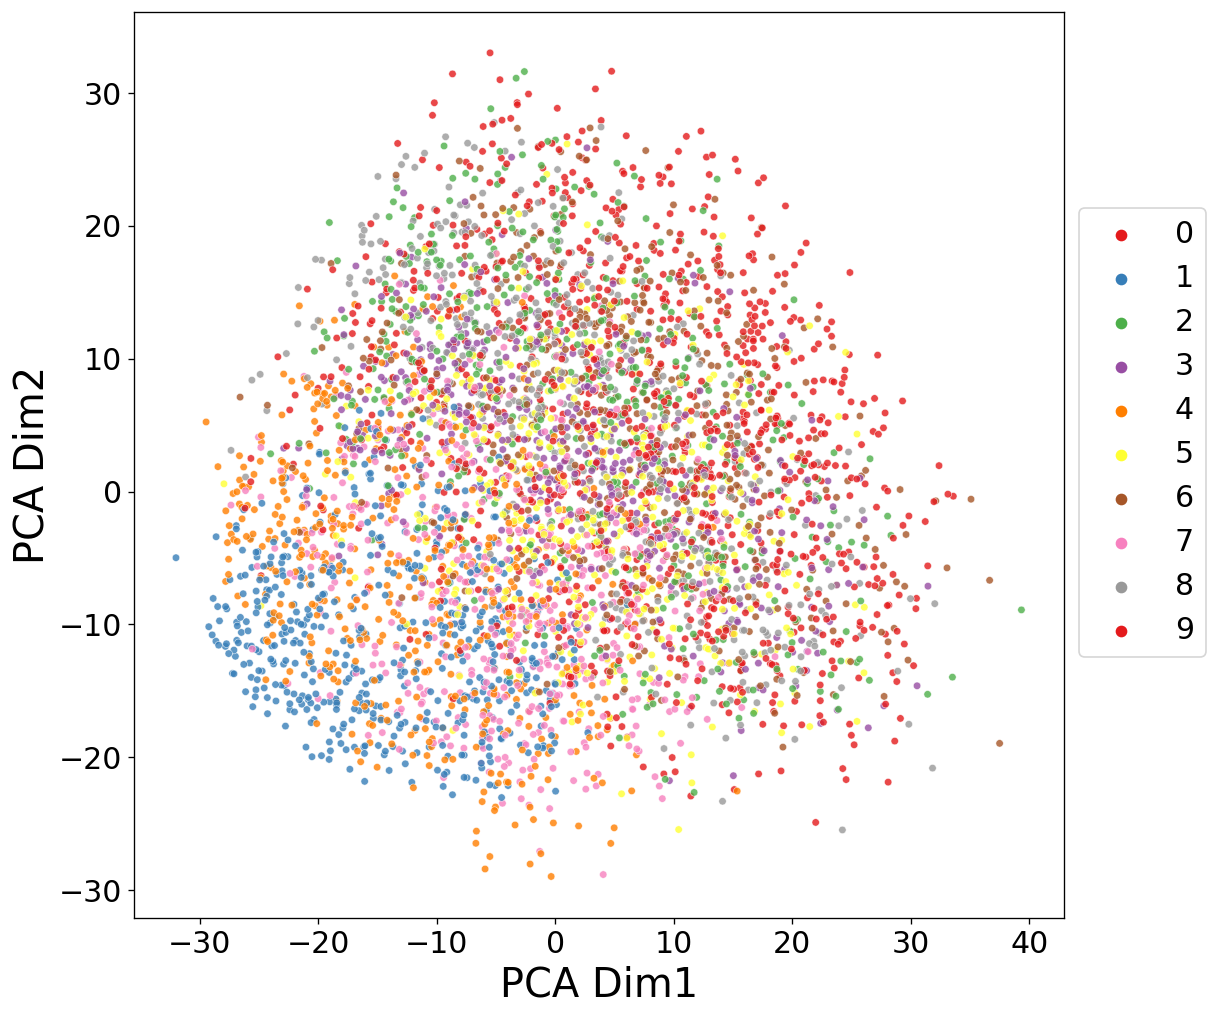

In [137]:
vgg16_pca_embedded_df = pd.DataFrame(vgg16_pca_embedded,index=vgg16_label)
vgg16_pca_embedded_df = vgg16_pca_embedded_df.reset_index()
vgg16_pca_embedded_df['index'] = vgg16_pca_embedded_df['index'].astype(int)
vgg16_pca_embedded_df_plot = vgg16_pca_embedded_df.loc[range(5000),:]
vgg16_pca_embedded_df_plot.columns = ['Label','PCA Dim1', 'PCA Dim2']
plt.figure(figsize=(10,10),dpi=120)
ax = sns.scatterplot(x='PCA Dim1', y='PCA Dim2',hue='Label',data=vgg16_pca_embedded_df_plot,
                     palette='Set1',alpha=0.8,s=20,legend='full') # tab10  Set1  husl 
ax.set_xlabel('PCA Dim1', fontsize=24)
ax.set_ylabel('PCA Dim2', fontsize=24)
ax.tick_params(labelsize=18)
# ax.set_title('PCA of VGG16', fontsize=30, position=(0.5,1.02))
legend = plt.legend(bbox_to_anchor=(1, 0.8),fontsize='18')
plt.show()

### tSNE of VGG16
t-SNE(t-distributed stochastic neighbor embedding)

In [17]:
start = time.time()

vgg16_tsne_embedded = TSNE(n_components=2).fit_transform(vgg16_feature)

end = time.time()
end - start

185.42861533164978

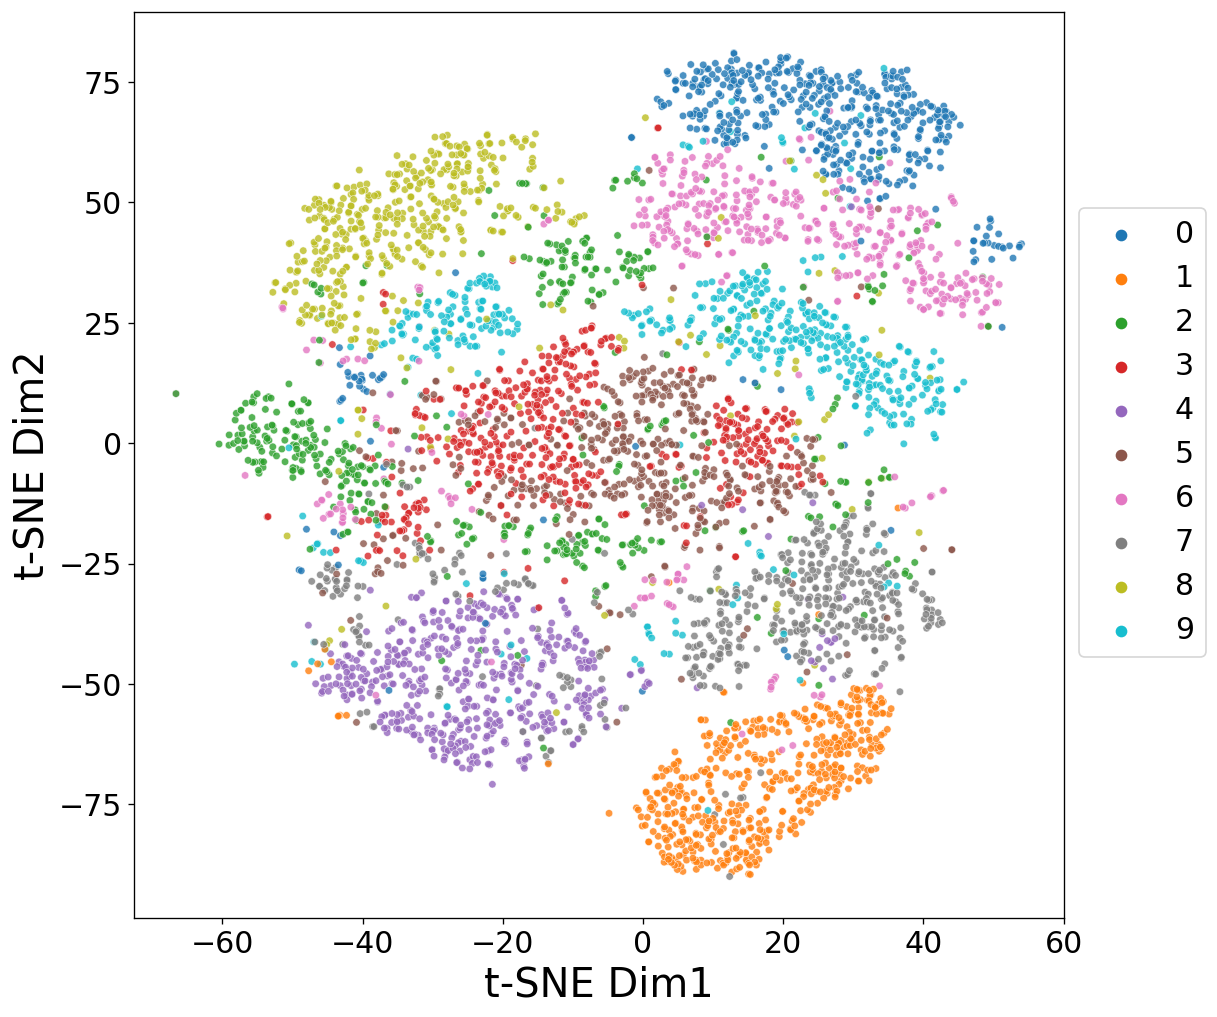

In [135]:
vgg16_tsne_embedded_df = pd.DataFrame(vgg16_tsne_embedded,index=vgg16_label)
vgg16_tsne_embedded_df = vgg16_tsne_embedded_df.reset_index()
vgg16_tsne_embedded_df['index'] = vgg16_tsne_embedded_df['index'].astype(int)
vgg16_tsne_embedded_df_plot = vgg16_tsne_embedded_df.loc[range(5000),:]
vgg16_tsne_embedded_df_plot.columns = ['Label','tSNE Dim1', 'tSNE Dim2']
plt.figure(figsize=(10,10),dpi=120)
ax = sns.scatterplot(x='tSNE Dim1', y='tSNE Dim2',hue='Label',data=vgg16_tsne_embedded_df_plot,
                     palette='tab10',alpha=0.8,s=20,legend='full')
ax.set_xlabel('t-SNE Dim1', fontsize=24)
ax.set_ylabel('t-SNE Dim2', fontsize=24)
ax.tick_params(labelsize=18)
# ax.set_title('t-SNE of VGG16', fontsize=30, position=(0.5,1.02))
legend = plt.legend(bbox_to_anchor=(1, 0.8),fontsize='18')
plt.show()

### Classifications based on features extracted by vgg16

In [21]:
from sklearn.model_selection import cross_validate

In [85]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

start = time.time()

lda = LinearDiscriminantAnalysis()

lda_results = cross_validate(lda, vgg16_feature[:5000], vgg16_label[:5000], cv=3, scoring='accuracy')
lda_results = lda_results['test_score']

end = time.time()
end - start, lda_results

(48.31731700897217, array([0.78224355, 0.76664667, 0.76470588]))

In [86]:
from sklearn.linear_model import LogisticRegression

start = time.time()

logistic_regression = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

logistic_regression_results = cross_validate(logistic_regression, vgg16_feature[:5000], vgg16_label[:5000], cv=3, scoring='accuracy')
logistic_regression_results = logistic_regression_results['test_score']

end = time.time()
end - start, logistic_regression_results

d:\program\python\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
d:\program\python\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extr

(5.999151229858398, array([0.95560888, 0.940012  , 0.95738295]))

In [87]:
from sklearn import svm

start = time.time()

linear_svc = svm.LinearSVC()

svm_results = cross_validate(linear_svc, vgg16_feature[:5000], vgg16_label[:5000], cv=3, scoring='accuracy')
svm_results = svm_results['test_score']

end = time.time()
end - start, svm_results

d:\program\python\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\program\python\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
d:\program\python\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(22.395396947860718, array([0.96640672, 0.95920816, 0.96758703]))

In [88]:
from sklearn.ensemble import RandomForestClassifier

start = time.time()

random_forest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

random_forest_results = cross_validate(random_forest, vgg16_feature[:5000], vgg16_label[:5000], cv=3, scoring='accuracy')
random_forest_results = random_forest_results['test_score']

end = time.time()
end - start, random_forest_results

(1.6237835884094238, array([0.81223755, 0.80623875, 0.80912365]))

In [89]:
lda_results,logistic_regression_results,svm_results,random_forest_results

(array([0.78224355, 0.76664667, 0.76470588]),
 array([0.95560888, 0.940012  , 0.95738295]),
 array([0.96640672, 0.95920816, 0.96758703]),
 array([0.81223755, 0.80623875, 0.80912365]))

In [90]:
lda_results.mean(),logistic_regression_results.mean(),svm_results.mean(),random_forest_results.mean()

(0.7711987014361833,
 0.9510012763353691,
 0.9644006372795069,
 0.8091999847329454)

In [91]:
lda_results.std(),logistic_regression_results.std(),svm_results.std(),random_forest_results.std()

(0.007849976477019533,
 0.007804273223604595,
 0.0037031216102362207,
 0.0024495947127580932)

In [181]:
from sklearn.linear_model import LogisticRegression


logistic_regression = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
logistic_regression.fit(features, labels)
label_pred = logistic_regression.predict(features)


d:\program\python\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [182]:
pred_features_classified=[]

for c in range(10):
    pred_sample_order = np.where(label_pred == c)[0]
    pred_features_single_class = np.zeros((len(pred_sample_order), num_feature))
    for i in range(len(pred_sample_order)):
        pred_features_single_class[i] = features[pred_sample_order[i]]
    pred_features_classified.append(pred_features_single_class)

In [183]:
pred_mean_class = np.zeros((num_feature, 10))
pred_mean_class_transpose = pred_mean_class.T

for c in range(10):
    pred_mean_class_transpose[c] = np.mean(pred_features_classified[c], axis=0)

pred_mean_class=pred_mean_class_transpose.T

In [184]:
std_cos=np.zeros(10)

for c in range(10):
    mu_c=mean_class[:,c].reshape(num_feature, 1)
    mu_g=mean_global.reshape(num_feature, 1)
    mu_c_pred=pred_mean_class[:,c].reshape(num_feature, 1)
    mu_diff=mu_c-mu_g
    mu_diff_pred=mu_c_pred-mu_g
    inner_out=np.inner(mu_diff.T, mu_diff_pred.T)

    norm2_mu=np.linalg.norm(mu_diff, ord=2, keepdims=True)
    norm2_mu_pred=np.linalg.norm(mu_diff_pred, ord=2, keepdims=True)
    norm_mul=norm2_mu*norm2_mu_pred
    
    std_cos[c]=inner_out/norm_mul

    
std_cos_out=np.std(std_cos)
avg_cos_out=np.mean(std_cos+1/9)

In [185]:
std_cos_out,avg_cos_out

(4.0640835625101184e-16, 1.111111111111111)